In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing your images
image_dir = './documents'  # Directory with original images
preprocessed_dir = './documents/preprocessed_images'  # Directory to save preprocessed images

# Ensure the preprocessed images directory exists
os.makedirs(preprocessed_dir, exist_ok=True)

# List all files in the directory
image_files = os.listdir(image_dir)

# Open each image file and convert to grayscale
images = [(file, Image.open(os.path.join(image_dir, file)).convert('L')) for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]

# Preprocessing parameters
left = 232
top = 60
img_width = 495
img_height = 475
right = left + img_width
bottom = top + img_height

# Preprocess images
cropped_images = [(file, img.crop((left, top, right, bottom))) for file, img in images]

# Convert to numpy arrays
cv_images = [(file, np.array(image)) for file, image in cropped_images]

# Define constants
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
MAX_DELTA = 200
crop_top = 290
crop_height = 100
crop_bottom = crop_top + crop_height
crop_left = 215
crop_width = 125
crop_right = crop_left + crop_width
MIN_DELTA_X = -crop_left
MAX_DELTA_X = img_width - crop_right
MIN_DELTA_Y = -crop_top
MAX_DELTA_Y = img_height - crop_bottom

from sklearn.cluster import DBSCAN

cluster_model = DBSCAN(eps=10, min_samples=5)

def alignImages(im1, im2):
    try:
        if len(im1.shape) == 3:
            im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        else:
            im1Gray = im1
            im2Gray = im2

        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = list(matcher.match(descriptors1, descriptors2, None))

        matches.sort(key=lambda x: x.distance, reverse=False)
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        matches = matches[:numGoodMatches]

        if not matches:
            print("No good matches found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], None

        match_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        deltas = np.zeros((len(matches), 2))
        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt
            deltas[i] = points2[i] - points1[i]

        deltas = deltas[np.where((deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y))]

        if len(deltas) == 0:
            print("No valid deltas found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image

        associations = cluster_model.fit_predict(deltas)
        clusters = np.unique(associations)
        cluster_points = np.where(associations == 0)
        offset = np.average(deltas[cluster_points], axis=0)

        return offset, deltas, cluster_points, match_image
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Prepare image dataset
image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)

for i, (filename, image) in enumerate(cv_images):
    offset_left, offset_top = alignImages(cv_images[0][1], image)[0]

    if np.isnan(offset_left) or np.isnan(offset_top):
        print(f"Invalid offsets for image {i}: offset_left={offset_left}, offset_top={offset_top}")
        continue

    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)

    if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
        cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
        image_dataset[i] = cropped_image
        # Save preprocessed image with the original filename
        preprocessed_path = os.path.join(preprocessed_dir, filename)
        Image.fromarray(cropped_image).save(preprocessed_path)
    else:
        print(f"Cropping out of bounds for image {i}: cropped_top={cropped_top}, cropped_bottom={cropped_bottom}, cropped_left={cropped_left}, cropped_right={cropped_right}")

print(image_dataset.shape)


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Ex

Invalid offsets for image 8: offset_left=nan, offset_top=nan
Invalid offsets for image 10: offset_left=nan, offset_top=nan
Invalid offsets for image 13: offset_left=nan, offset_top=nan
Invalid offsets for image 15: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 57: offset_left=nan, offset_top=nan
Invalid offsets for image 66: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 82: offset_left=nan, offset_top=nan
Invalid offsets for image 86: offset_left=nan, offset_top=nan
Invalid offsets for image 87: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 100: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 116: offset_left=nan, offset_top=nan
Invalid offsets for image 119: offset_left=nan, offset_top=nan
Invalid offsets for image 122: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 137: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 195: offset_left=nan, offset_top=nan
(205, 100, 125)


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing your images
image_dir = './documents'  # Directory with original images
preprocessed_dir = './documents/preprocessed_images'  # Directory to save preprocessed images

# Ensure the preprocessed images directory exists
os.makedirs(preprocessed_dir, exist_ok=True)

# List all files in the directory
image_files = os.listdir(image_dir)

# Open each image file and convert to grayscale
images = [(file, Image.open(os.path.join(image_dir, file)).convert('L')) for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]

# Preprocessing parameters
left = 232
top = 60
img_width = 495
img_height = 475
right = left + img_width
bottom = top + img_height

# Preprocess images
cropped_images = [(file, img.crop((left, top, right, bottom))) for file, img in images]

# Convert to numpy arrays
cv_images = [(file, np.array(image)) for file, image in cropped_images]

# Define constants
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
MAX_DELTA = 200
crop_top = 290
crop_height = 100
crop_bottom = crop_top + crop_height
crop_left = 215
crop_width = 125
crop_right = crop_left + crop_width
MIN_DELTA_X = -crop_left
MAX_DELTA_X = img_width - crop_right
MIN_DELTA_Y = -crop_top
MAX_DELTA_Y = img_height - crop_bottom

from sklearn.cluster import DBSCAN

cluster_model = DBSCAN(eps=10, min_samples=5)

def alignImages(im1, im2):
    try:
        if len(im1.shape) == 3:
            im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        else:
            im1Gray = im1
            im2Gray = im2

        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = list(matcher.match(descriptors1, descriptors2, None))

        matches.sort(key=lambda x: x.distance, reverse=False)
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        matches = matches[:numGoodMatches]

        if not matches:
            print("No good matches found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], None

        match_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        deltas = np.zeros((len(matches), 2))
        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt
            deltas[i] = points2[i] - points1[i]

        deltas = deltas[np.where((deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y))]

        if len(deltas) == 0:
            print("No valid deltas found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image

        associations = cluster_model.fit_predict(deltas)
        clusters = np.unique(associations)
        if len(clusters) == 0 or (clusters == -1).all():
            print("No clusters found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image
        
        cluster_points = np.where(associations == 0)
        if len(cluster_points[0]) == 0:
            print("No cluster points found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image
        
        offset = np.average(deltas[cluster_points], axis=0)

        return offset, deltas, cluster_points, match_image
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Prepare image dataset
image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)

for i, (filename, image) in enumerate(cv_images):
    preprocessed_path = os.path.join(preprocessed_dir, filename)

    # Check if the preprocessed image already exists
    if os.path.exists(preprocessed_path):
        print(f"Preprocessed image already exists: {preprocessed_path}")
        continue

    offset_left, offset_top = alignImages(cv_images[0][1], image)[0]

    if np.isnan(offset_left) or np.isnan(offset_top):
        print(f"Invalid offsets for image {i} ({filename}): offset_left={offset_left}, offset_top={offset_top}")
        continue

    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)

    if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
        cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
        image_dataset[i] = cropped_image
        # Save preprocessed image with the original filename
        Image.fromarray(cropped_image).save(preprocessed_path)
    else:
        print(f"Cropping out of bounds for image {i} ({filename}): cropped_top={cropped_top}, cropped_bottom={cropped_bottom}, cropped_left={cropped_left}, cropped_right={cropped_right}")

print(image_dataset.shape)


Preprocessed image already exists: ./documents/preprocessed_images/MMED-080_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-007_image_data_2_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-024_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-027_image_data_2_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-061_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-002_image_data_2_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-003_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-047_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-051_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-1

Loaded 205 images.
Training set size: 164
Testing set size: 41


2024-06-10 07:56:26.479918: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 07:56:26.483162: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 07:56:26.512389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 07:56:27.491766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/25


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-10 07:56:29.379753: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


1/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 25.5656 - mae: 5.0437

2024-06-10 07:56:29.615266: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2024-06-10 07:56:29.712780: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


2/6 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 23.3264 - mae: 4.7943

2024-06-10 07:56:29.965990: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2024-06-10 07:56:30.050400: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 16.1840 - mae: 3.7074 - val_loss: 1.9681 - val_mae: 1.1826
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 6.1002 - mae: 2.2510 - val_loss: 2.1038 - val_mae: 1.2430
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 3.8069 - mae: 1.6239 - val_loss: 0.8778 - val_mae: 0.7603
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 2.3000 - mae: 1.2163 - val_loss: 1.3740 - val_mae: 0.9555
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 2.3343 - mae: 1.2475 - val_loss: 0.8360 - val_mae: 0.7309
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - loss: 1.6986 - mae: 1.0474 - val_loss: 0.7116 - val_mae: 0.6609
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 1.4032 - mae: 0.9802 - val_loss: 0.5729 - val_mae: 0.5919
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - loss: 1.2308 - mae: 0.8614 - val_loss: 0.4940 - val_mae: 0.5572
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 1.1285 - mae: 0.8588 - v

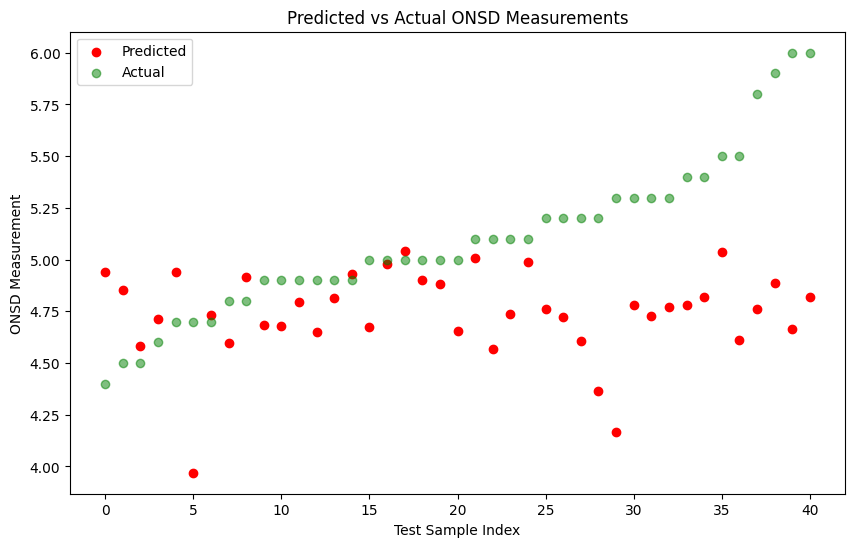

Mean Absolute Error (MAE): 0.42910945241044207
Root Mean Square Error (RMSE): 0.554322728112145
[[6.         4.81687164]
 [4.9        4.93106937]
 [4.9        4.81579828]
 [5.4        4.77895117]
 [4.9        4.68185806]
 [4.8        4.91697073]
 [5.9        4.88557816]
 [5.2        4.36252642]
 [4.7        4.94060373]
 [5.         4.65483904]]


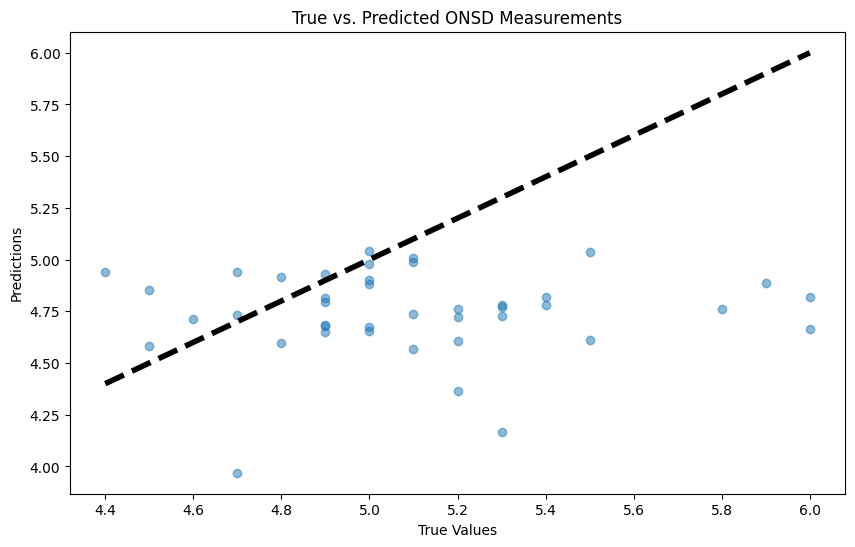

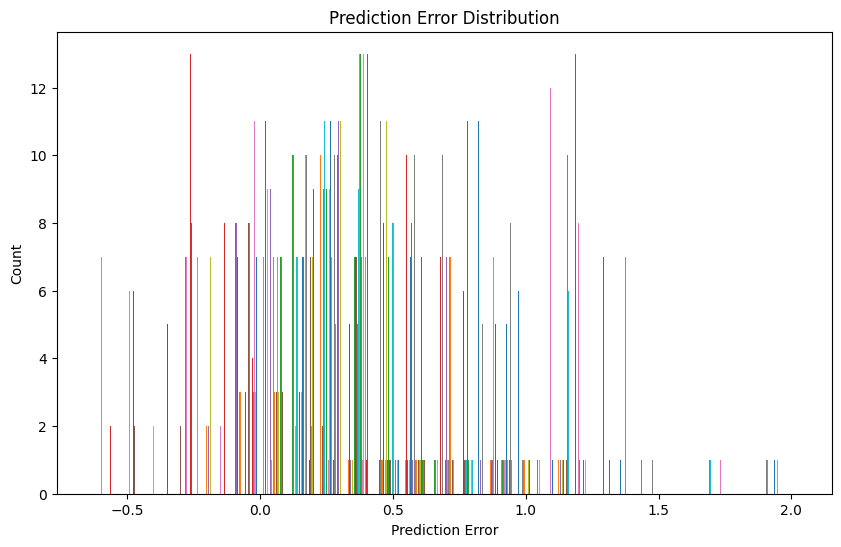

In [3]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Load the Excel file with ONSD measurements and labels
excel_file = 'Meta_pic_3.xlsx'  # Adjust path as needed
df = pd.read_excel(excel_file)

# Convert necessary columns to strings and create a filename column following the naming convention
df['filename'] = df['record_id'].astype(str) + '_image_data_' + df['redcap_repeat_instance'].astype(str) + '_raw_image.jpg'

# Correct base directory for your preprocessed images
preprocessed_dir = r"./documents/preprocessed_images"

# Function to load images based on the filename
def load_images(df, base_dir):
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_dir, row['filename'])  # Use 'filename' directly as filename
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))  # Resize for uniformity
                img_array = np.array(img)
                images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images)

# Load images and corresponding ONSD measurements
images = load_images(df, preprocessed_dir)
df['onsd'] = df['onsd'].astype(str).str.replace(',', '.').astype(float)  # Convert ONSD values to float
onsd_measurements = df['onsd'].values

# Check if any images were loaded
if len(images) == 0:
    print("No images were loaded. Please check the image paths and file names.")
else:
    print(f"Loaded {len(images)} images.")

# Normalize images
images = images / 255.0

# Reshape images to add the single channel dimension for grayscale images
images = images.reshape(images.shape + (1,))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Simple CNN model architecture
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Single output node for regression
    ])
    return model

model = build_model()
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])  # MSE is a common loss for regression

history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

# Make predictions
predictions = model.predict(X_test)

import matplotlib.pyplot as plt

order = y_test.argsort(axis=None).reshape(predictions.shape)
sorted_predictions = predictions.ravel()[order]
sorted_data = y_test.ravel()[order]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(predictions)), sorted_predictions, color='r', label='Predicted')
plt.scatter(range(len(y_test)), sorted_data, color='g', alpha=0.5, label='Actual')
plt.title('Predicted vs Actual ONSD Measurements')
plt.xlabel('Test Sample Index')
plt.ylabel('ONSD Measurement')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")

import matplotlib.pyplot as plt

# Assuming 'predictions' is a numpy array of your model's predicted ONSD measurements
# and 'y_test' is the true ONSD measurements

# Compare predictions with actual values
comparison = np.column_stack((y_test, predictions))

# Print the first few comparisons to check
print(comparison[:10])

# Plotting the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted ONSD Measurements')
plt.show()

# Plotting the error distribution
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


In [4]:
# Print the first few comparisons to check
print(comparison[:30])

[[6.         4.81687164]
 [4.9        4.93106937]
 [4.9        4.81579828]
 [5.4        4.77895117]
 [4.9        4.68185806]
 [4.8        4.91697073]
 [5.9        4.88557816]
 [5.2        4.36252642]
 [4.7        4.94060373]
 [5.         4.65483904]
 [5.5        4.61018515]
 [5.         4.88314581]
 [5.2        4.72278833]
 [5.3        4.72829437]
 [4.7        3.96940279]
 [5.2        4.76270628]
 [4.4        4.93885374]
 [5.4        4.8207469 ]
 [5.2        4.60698843]
 [5.         5.04275131]
 [5.         4.90195608]
 [5.1        5.006598  ]
 [5.1        4.56571341]
 [4.5        4.85242081]
 [5.3        4.77933073]
 [4.6        4.71221733]
 [4.9        4.6506753 ]
 [4.9        4.79514313]
 [5.1        4.73572016]
 [5.3        4.16544485]]


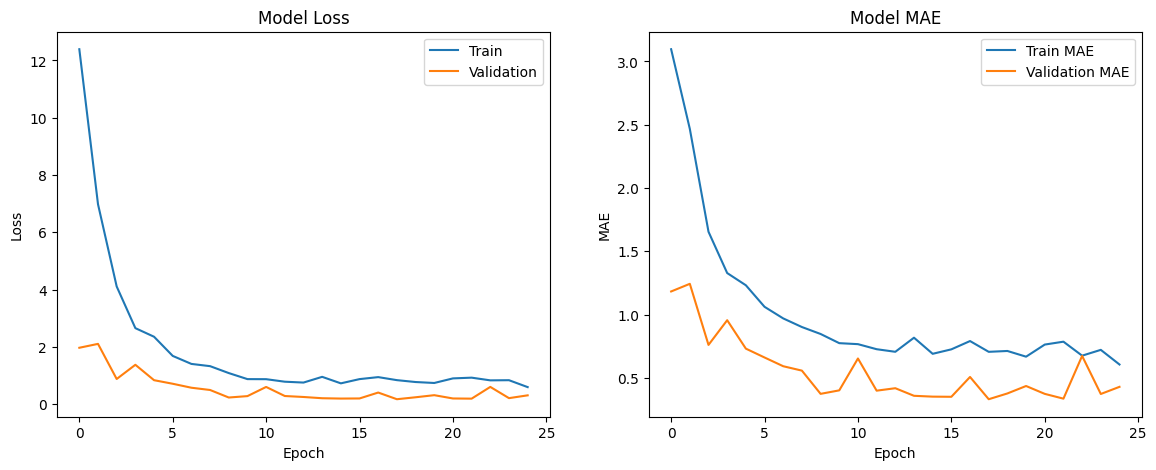

   Actual ONSD  Predicted ONSD  Absolute Error
0          6.0        4.816872        1.183128
1          4.9        4.931069        0.031069
2          4.9        4.815798        0.084202
3          5.4        4.778951        0.621049
4          4.9        4.681858        0.218142
5          4.8        4.916971        0.116971
6          5.9        4.885578        1.014422
7          5.2        4.362526        0.837474
8          4.7        4.940604        0.240604
9          5.0        4.654839        0.345161


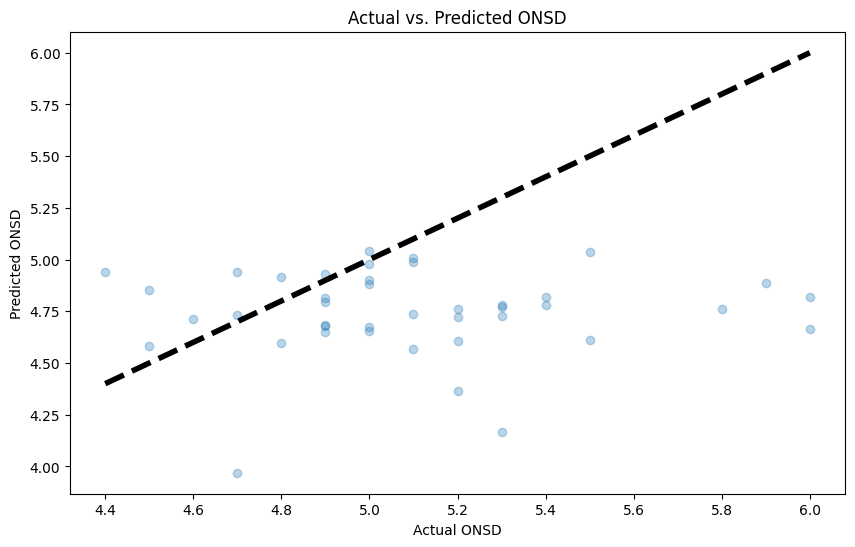

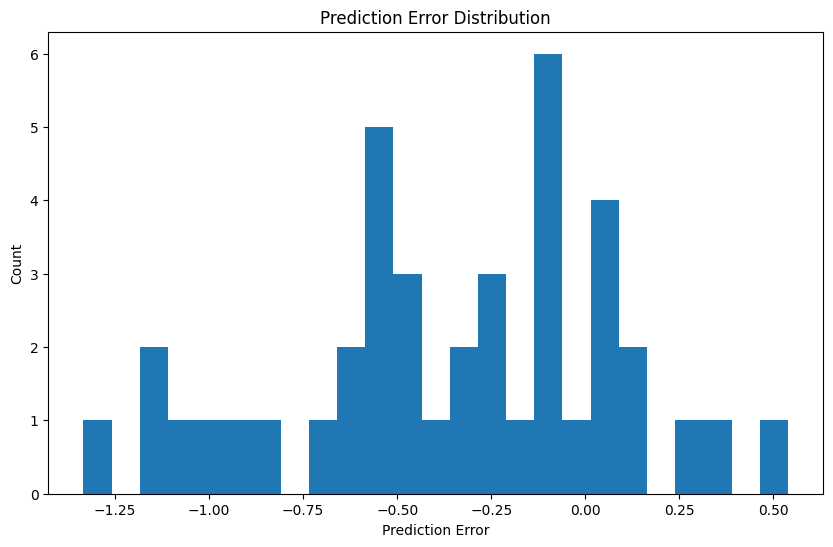

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the training history
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

# Assuming 'predictions' is a numpy array with the predicted ONSD values
# And 'y_test' is the actual ONSD measurements from the test set

# Convert predictions to a 1D array if it's not already
predictions = predictions.flatten()

# Create a DataFrame for a cleaner display
comparison_df = pd.DataFrame({'Actual ONSD': y_test, 'Predicted ONSD': predictions})

# Add a column for absolute error
comparison_df['Absolute Error'] = np.abs(comparison_df['Actual ONSD'] - comparison_df['Predicted ONSD'])

# Display several examples
print(comparison_df.head(10))

# Plotting Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual ONSD')
plt.ylabel('Predicted ONSD')
plt.title('Actual vs. Predicted ONSD')
plt.show()

# Plotting the error distribution
errors = predictions - y_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


In [11]:
#install weights and biases
!pip install wandb
#install wandb keras callback
!pip install wandb keras

In [27]:
import wandb
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
import os


wandb.init(settings=wandb.Settings(start_method="thread"))

# Configure the sweep
sweep_config = {
    'method': 'random',  # grid, random
    'metric': {
        'name': 'val_mae',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'values': [10, 25, 50]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'conv_layers': {
            'values': [1, 2, 3]
        },
        'dense_layers': {
            'values': [1, 2]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="onsd-prediction")

# Load and preprocess your data
def load_images(df, base_dir):
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_dir, row['filename'])
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))  # Resize for uniformity
                img_array = np.array(img)
                images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images)

# Directory and CSV file paths
preprocessed_dir = "./documents/preprocessed_images"
excel_file = "./workspaces/ONSD_Explore/Meta_pic_3.xlsx"

# Load DataFrame and preprocess
df = pd.read_excel(excel_file)
df['filename'] = df.apply(lambda row: f"{row['record_id']}_image_data_{row['redcap_repeat_instance']}_raw_image.jpg", axis=1)

# Load images and corresponding ONSD measurements
images = load_images(df, preprocessed_dir)
df['onsd'] = df['onsd'].str.replace(',', '.').astype(float)  # Convert ONSD values to float
onsd_measurements = df['onsd'].values

# Normalize images
images = images / 255.0
images = images.reshape(images.shape + (1,))  # Reshape to add the single channel dimension for grayscale images

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.2, random_state=42)

def train():
    wandb.init()
    config = wandb.config

    # Define your model
    model = Sequential()
    for _ in range(config.conv_layers):
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))
    model.add(Flatten())
    for _ in range(config.dense_layers):
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=config.learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train the model
    model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_test, y_test),
              callbacks=[WandbCallback()])

    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test MAE: {test_mae}")

# Run the sweep
wandb.agent(sweep_id, train)

# Update run configuration
api = wandb.Api()
run = api.run("your-entity-name/onsd-prediction/<run_id>")
run.config["key"] = updated_value
run.update()


wandb: ERROR Control-C detected -- Run data was not synced
